## Start with import necessary libs

In [1]:
# Standard library imports
import json
import time
from collections import Counter

# Third-party library imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from textblob import TextBlob
import ollama
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch


from nltk.corpus import stopwords


2025-03-07 13:47:25.425347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def test():
    URL = "https://www.trustpilot.com/review/www.keytradebank.be?languages=all&page=4"
    HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    response = requests.get(URL, headers=HEADERS)
    print(response.status_code)  # Should return 200 if the request is successful
    soup = BeautifulSoup(response.content, "html.parser")
    reviews = []

    # Locate the script tag containing the JSON data
    script_tag = soup.find("script", id="__NEXT_DATA__")
    if not script_tag:
        print("Structured data script not found.")

    # Parse the JSON data
    data = json.loads(script_tag.string)
    review_data = data['props']['pageProps']['reviews']
    return review_data
test()

200


[{'id': '677c35f9008290dcc9422b32',
  'filtered': False,
  'pending': False,
  'text': 'Simple, digital, et gratuit ',
  'rating': 5,
  'labels': {'merged': None,
   'verification': {'isVerified': True,
    'createdDateTime': '2025-01-06T21:58:49.000Z',
    'reviewSourceName': 'BusinessGeneratedLink',
    'verificationSource': 'invitation',
    'verificationLevel': 'invited',
    'hasDachExclusion': False}},
  'title': 'Simple',
  'likes': 0,
  'dates': {'experiencedDate': '2025-01-06T00:00:00.000Z',
   'publishedDate': '2025-01-06T21:58:49.000Z',
   'updatedDate': None},
  'report': None,
  'hasUnhandledReports': False,
  'consumer': {'id': '62c319045eb62f00121a7ef1',
   'displayName': 'Michaël De Kerf',
   'imageUrl': '',
   'numberOfReviews': 2,
   'countryCode': 'BE',
   'hasImage': False,
   'isVerified': False},
  'reply': None,
  'consumersReviewCountOnSameDomain': 1,
  'consumersReviewCountOnSameLocation': None,
  'productReviews': [],
  'language': 'fr',
  'location': None},
 

### Data Collection through Web Scraping

#### Why Web Scraping?
- Trustpilot provides structured data in a `<script>` tag (`id="__NEXT_DATA__`), making extraction **reliable and efficient**.
- Extracting JSON data avoids **complex HTML parsing**, reducing errors.

#### Ethical and Legal Considerations
- **Set overhead time to avoid excessive requests** (`sleep()` to prevent throttling and IP bans).
- **Non-intrusive scraping** → Pulls **structured JSON** instead of aggressive HTML parsing.
- **Privacy Protection** → **Usernames are removed** to protect personal data.
- **Compliance** → Checking **robots.txt and Trustpilot's Terms of Service (ToS)** before scraping.

#### Alternative: Using Trustpilot API
- **Using API is the preferred option** for businesses, as it provides **official access to reviews**.
- Requires **business API key** → Recommended if the organization has **formal access**.
- API ensures **long-term data access stability** compared to web scraping.

---

In [3]:
### reference:https://www.youtube.com/watch?v=VD0wIiLVSRA

def extract_reviews(page_number, lan, all_reviews):
    """Scrapes Trustpilot reviews, extracting username, rating, review text, date, and country."""
    # response = requests.get(f"{URL}?languages=all&page={page_number}", headers=HEADERS)
    if page_number ==1:
        URL = f"https://www.trustpilot.com/review/www.keytradebank.be?language={lan}"
    else:
        URL = f"https://www.trustpilot.com/review/www.keytradebank.be?language={lan}&page={page_number}"
    HEADERS = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(URL, headers=HEADERS)

    if response.status_code != 200:
        print(f"Failed to retrieve page {page_number}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")
    reviews = []

    # Locate the script tag containing the JSON data
    script_tag = soup.find("script", id="__NEXT_DATA__")
    if not script_tag:
        print("Structured data script not found.")
        return []

    # Parse the JSON data
    try:
        data = json.loads(script_tag.string)
        review_data = data['props']['pageProps']['reviews']
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON data: {e}")
        return []

    # Extract review details
    for review in review_data:  # Ensure 'review' is defined here
        username = review.get('consumer', {}).get('displayName', 'Anonymous')
        rating = review.get('rating', 'N/A')
        title = review.get('title', 'N/A')
        language = review.get('language', 'N/A')
        country = review.get('consumer', {}).get('countryCode', 'N/A')
        review_text = review.get('text', 'N/A')
        date = review.get('dates', {}).get('publishedDate', 'N/A')

        review_entry = {
            "username": username,
            "rating": rating,
            "language": language,
            "title": title,
            "review_text": review_text,
            "date": date,
            "country": country
        }

        # Ensure data is not duplicated
        if review_entry not in all_reviews:
            reviews.append(review_entry)
        else:
            print("Data duplicated, skipping entry.")

    return reviews


In [4]:
all_reviews = []


In [ ]:
for lan in ['en','nl','fr']:
    for page in range(1,10):
        reviews = extract_reviews(page, lan, all_reviews)
        # To avoid throttling
        time.sleep(2)
        if not reviews:
            print(f"{page} stop")
            break
        all_reviews.extend(reviews)


### 🛑 Scraping Limitation
⚠ **Issue:** The scraping process is limited because Trustpilot has a **"Show All Languages"** button on the webpage. This means that not all reviews are loaded by default, which affects the ability to scrape reviews across different languages.  
💡 **Solution:** Consider simulating a click on the **"Show All Languages"** button using Selenium or try accessing a direct API if available.

In [6]:
# df = pd.read_csv('keytradebank_reviews.csv')
df = pd.read_csv('trustpilot_reviews_with_falcon3.csv')

df

,username,rating,language,title,review_text,date,country,sentiment,summary,sentiment_clean
0,trustpiloter,1,en,reply to Veronique,I got a reply from Veronique Keytrade and I ca...,2025-02-25,BE,Negative,The customer had multiple issues with Veroniqu...,Negative
1,Mark Lerno,5,en,Great start with easy application and good com...,"I am an ex-Belgian, now residing in Australia,...",2025-02-02,AU,Positive,The customer is satisfied with Keytrade's conv...,Positive
2,Client MCM,4,en,info concise,info concise,2025-01-13,BE,Neutral,Concise information.,Neutral
3,J De Greef,5,en,No complaints,No issues with online banking without having o...,2025-01-09,BE,Positive,The customer found no issues with online banki...,Positive
4,Monir Moutawakkil,5,en,Login simplification,Login simplification,2025-01-02,BE,Positive,"The reviewer found the ""Login simplification"" ...",Positive
...,...,...,...,...,...,...,...,...,...,...
627,"Dhr. Bernaerts, Ivo",1,nl,Ik lees hier telkens dezelfde klachten,Ik lees hier telkens dezelfde klachten. Ik pro...,2021-10-08,BE,Negative,The customer is disappointed with their curren...,Negative
628,Consumer,1,nl,Slechtste bank aller tijden.,Geld dat op een geblokkeerde rekening staat na...,2021-09-25,BE,NaN,- **Sentiment:** Negative,N/a
629,Cj,1,nl,Zeer lang klant,"Zeer lang klant, maar nu komt er een vraag wie...",2021-09-06,NL,Negative,The customer is upset about the difficulty the...,Negative
630,C Jansen,1,nl,Deze bank sluit gewoon een zakelijke…,Deze bank sluit gewoon een zakelijke rekening ...,2021-09-04,BE,Positive,The customer is satisfied with the refund proc...,Positive


In [7]:
# df = pd.DataFrame(all_reviews)
# # Convert date format from ISO to YYYY-MM-DD
# # df['date'] = df['date'].apply(lambda x: x.split('T')[0] if isinstance(x,str) and x != 'N/A' else 'N/A')
# df

In [8]:
df.drop_duplicates(inplace= True)

In [9]:
# df.to_csv("keytradebank_reviews.csv", index=False)



**Warning:**  
You must not carry out in any way (including facilitating, permitting, or authorizing) any text mining, data mining, or web scraping of our platform for any purpose without our express permission.  
This includes the training and development of artificial intelligence systems or models.

**Solution:**  
Try to have overhead time not to overload the website.

📌 **Trustpilot API Information:**  
Trustpilot does have an API:  
- **Trustpilot Business API**  
  - API access requires a business account.


## Step 2: Preliminary Data Analysis



In [10]:
# Create true labels based on rating
def map_rating_to_sentiment(rating):
    if rating >3:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif rating <3:
        return "Negative"

df["true_label"] = df["rating"].apply(map_rating_to_sentiment)

In [11]:
# #Language distribution
# Word frequency analysis
# Sentiment distribution
# length distribution
# potential biases in the dataset

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/425593835.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=language_counts.index, y=language_counts.values, palette="coolwarm")


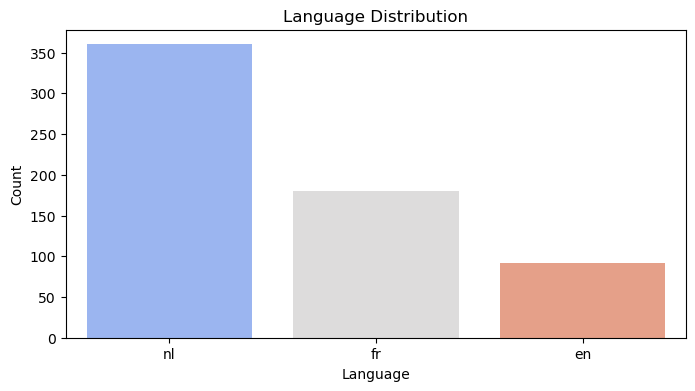

In [12]:

# 1. Language Distribution
language_counts = df['language'].value_counts()
plt.figure(figsize=(8, 4))
sns.barplot(x=language_counts.index, y=language_counts.values, palette="coolwarm")
plt.title("Language Distribution")
plt.xlabel("Language")
plt.ylabel("Count")
plt.show()


In [16]:
import nltk

# Download the 'punkt' tokenizer
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/chin-
[nltk_data]     jung.kuo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/599270537.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_freq_df["Frequency"], y=word_freq_df["Word"], palette="viridis")


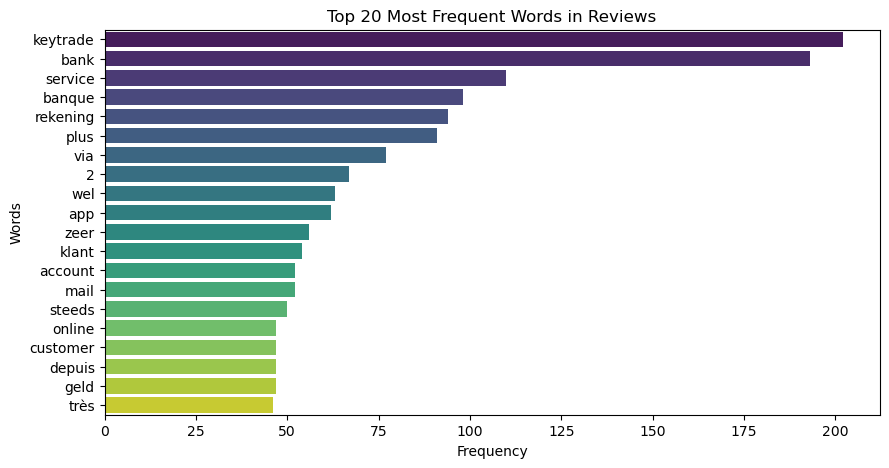

In [ ]:
# 2. Word Frequency Analysis (Simple Tokenization)
# Define custom stopwords (English, Dutch, French)
custom_stopwords = list(stopwords.words("english") + stopwords.words("dutch") + stopwords.words("french"))

def preprocess_text(text):
    """Preprocess text by removing stopwords and punctuation."""
    words = text.lower().split()  # Simple whitespace tokenization
    filtered_words = [word.strip(".,!?()[]") for word in words if word.isalnum() and word not in custom_stopwords]
    return filtered_words

# Apply text preprocessing
all_words = df['review_text'].dropna().apply(preprocess_text).explode()

# Word Frequency Analysis
word_freq = Counter(all_words).most_common(20)
word_freq_df = pd.DataFrame(word_freq, columns=["Word", "Frequency"])

# Plot Word Frequency
plt.figure(figsize=(10, 5))
sns.barplot(x=word_freq_df["Frequency"], y=word_freq_df["Word"], palette="viridis")
plt.title("Top 20 Most Frequent Words in Reviews")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


In [18]:
sentiment_counts = df['true_label'].value_counts(sort=False)
sentiment_counts

true_label
Negative    330
Positive    268
Neutral      34
Name: count, dtype: int64

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/2730199906.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


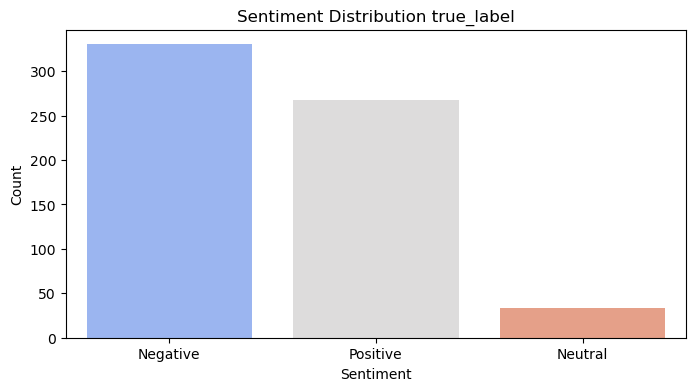

In [19]:
# 3. Sentiment Analysis - True label
sentiment_counts = df['true_label'].value_counts(sort=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Sentiment Distribution true_label")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/3383718501.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")


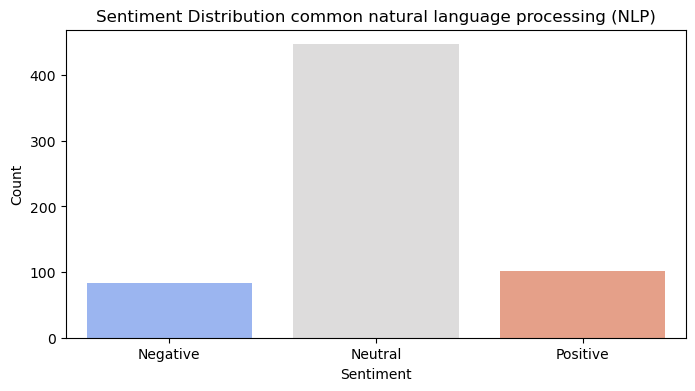

In [20]:
# 3. Sentiment Analysis
df['sentiment_TextBlob'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sentiment_counts = df['sentiment_TextBlob'].value_counts(bins=[-1, -0.001, 0.001, 1], sort=False)
sentiment_counts.index = ['Negative', 'Neutral', 'Positive']

plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="coolwarm")
plt.title("Sentiment Distribution common natural language processing (NLP)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

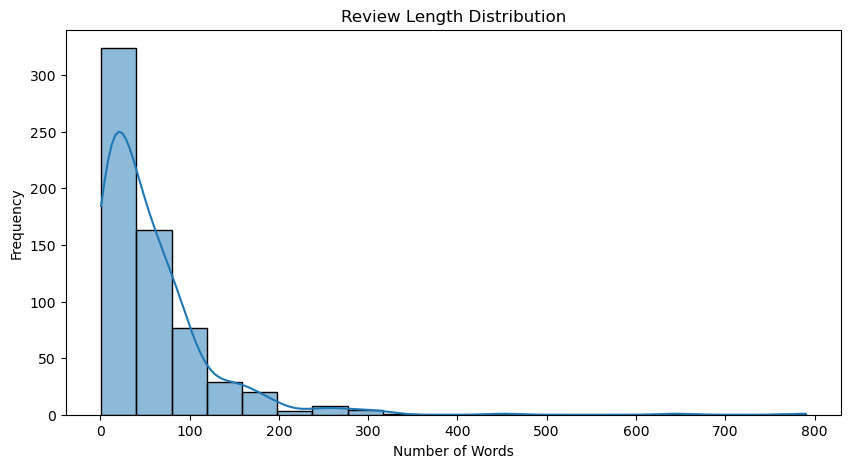

In [21]:
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=20, kde=True)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/438982306.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="magma")


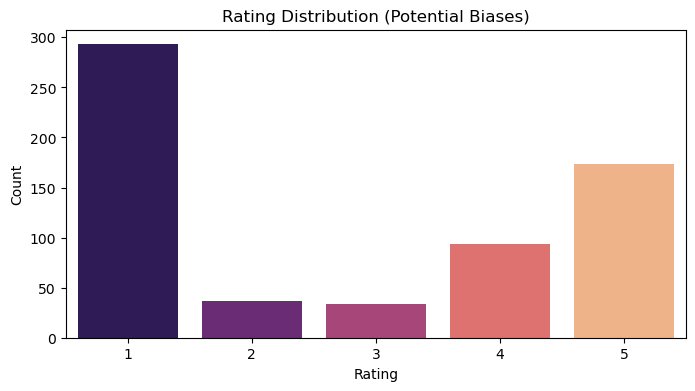

In [22]:
# 5. Potential Biases - Distribution of Ratings
rating_counts = df['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette="magma")
plt.title("Rating Distribution (Potential Biases)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## Step 3: Sentiment Classification



Traditional models: Logistic Regression, Naïve Bayes, SVM
Deep learning models: LSTMs, transformers (e.g., BERT)

In [23]:
def plot_confusion_matrix(df, true_col, pred_col, labels=None, cmap="Blues", title="Confusion Matrix"):
    """
    Generate and plot a confusion matrix.

    Parameters:
    - df (pd.DataFrame): DataFrame containing true and predicted labels.
    - true_col (str): Column name for true labels.
    - pred_col (str): Column name for predicted labels.
    - labels (list, optional): List of unique class labels in order.
    - cmap (str, optional): Colormap for visualization.
    - title (str, optional): Title for the plot.
    
    Returns:
    - None (displays the confusion matrix)
    """
    if labels is None:
        labels = sorted(df[true_col].unique())  # Get unique labels if not provided

    # Compute confusion matrix
    cm = confusion_matrix(df[true_col], df[pred_col], labels=labels)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    plt.figure(figsize=(6,5))
    disp.plot(cmap=cmap, values_format='d')
    plt.title(title)
    plt.show()

def evaluate_classification(df, true_col, pred_col, average='weighted'):
    """
    Compute accuracy, precision, recall, and F1-score for classification.

    Parameters:
    - df (pd.DataFrame): DataFrame containing true and predicted labels.
    - true_col (str): Column name for true labels.
    - pred_col (str): Column name for predicted labels.
    - average (str, optional): Averaging method for multi-class ('micro', 'macro', 'weighted', or None).
    
    Returns:
    - dict: A dictionary containing the four evaluation metrics.
    """
    metrics = {
        "Accuracy": accuracy_score(df[true_col], df[pred_col]),
        "Precision": precision_score(df[true_col], df[pred_col], average=average),
        "Recall": recall_score(df[true_col], df[pred_col], average=average),
        "F1 Score": f1_score(df[true_col], df[pred_col], average=average)
    }
    # Print formatted results
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics

### Naïve Bayes

In [24]:
# Define features (text) and labels (sentiment)
X = df["review_text"]  # Features
y = df["true_label"]   # Labels: "Negative", "Neutral", "Positive"

# Split data (80% train, 20% test) with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train Size: {len(X_train)}")
print(f"Test Size: {len(X_test)}")

Train Size: 505
Test Size: 127


In [25]:
# from sklearn.model_selection import StratifiedKFold

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     print(f"Train Size: {len(X_train)}, Test Size: {len(X_test)}")

In [26]:
# import nltk

# Load Dutch and French stopwords
# nltk.download("stopwords")
custom_stopwords = list(stopwords.words("english") + stopwords.words("dutch") + stopwords.words("french"))


# Create a Naïve Bayes pipeline
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords)), # , ngram_range=(1,2)
    ('clf', MultinomialNB())
])

# Train model
nb_pipeline.fit(X_train, y_train)

# Predict sentiment
y_pred = nb_pipeline.predict(X_test)

In [27]:
# Extract feature names from TF-IDF
feature_names = nb_pipeline.named_steps['tfidf'].get_feature_names_out()

# Extract class log probabilities
class_labels = nb_pipeline.named_steps['clf'].classes_
log_probabilities = nb_pipeline.named_steps['clf'].feature_log_prob_

# Show top words for each class
for i, class_label in enumerate(class_labels):
    top_words = np.argsort(log_probabilities[i])[-20:]  # Top 10 words
    print(f"Top words for {class_label}:")
    print([feature_names[j] for j in top_words])
    print()

Top words for Negative:
['wel', 'krijgen', 'app', 'klantendienst', 'customer', 'weken', 'banque', 'wachten', 'plus', 'geld', 'mails', 'klant', 'mail', 'steeds', 'antwoord', 'account', 'rekening', 'service', 'keytrade', 'bank']

Top words for Neutral:
['instantané', 'paiement', 'wel', 'gratis', 'duur', 'extra', 'keyprivate', 'beurs', 'interface', 'faire', 'paiements', 'contacteren', 'ligne', 'sait', 'payconiq', 'fonctionne', 'jullie', 'gsm', 'plus', 'toujours']

Top words for Positive:
['plus', 'facile', 'banken', 'utilisation', 'overzichtelijk', 'heel', 'bonne', 'goede', 'vlot', 'service', 'keytrade', 'gratis', 'simple', 'goed', 'zeer', 'très', 'app', 'bank', 'tevreden', 'banque']



In [28]:
df_NB = pd.DataFrame({'true_col': y_test, 'pred_col': y_pred})
print(len(df_NB))
metrics = evaluate_classification(df_NB,'true_col','pred_col')
"""before ngram
Accuracy: 0.8268
Precision: 0.7842
Recall: 0.8268
F1 Score: 0.8015
after bigrams
Accuracy: 0.8110
Precision: 0.7779
Recall: 0.8110
F1 Score: 0.7835
## some optimzation could do, remove redundant word
hyperparameter tunning
balance dataset
"""

127
Accuracy: 0.8268
Precision: 0.7842
Recall: 0.8268
F1 Score: 0.8015


/Users/chin-jung.kuo/miniconda3/envs/EDA_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'before ngram\nAccuracy: 0.8268\nPrecision: 0.7842\nRecall: 0.8268\nF1 Score: 0.8015\nafter bigrams\nAccuracy: 0.8110\nPrecision: 0.7779\nRecall: 0.8110\nF1 Score: 0.7835\n## some optimzation could do, remove redundant word\nhyperparameter tunning\nbalance dataset\n'

In [29]:
# ✅ Create Pipelines for Each Model
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords)),  # Convert text to TF-IDF
    ('nb', MultinomialNB(alpha=0.5))  # Train Naïve Bayes
])

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=custom_stopwords)),  # Convert text to TF-IDF
    ('lr', LogisticRegression(max_iter=1000))  # Train Logistic Regression
])

# ✅ Create Voting Classifier with Pipelines
ensemble = VotingClassifier(estimators=[("nb", nb_pipeline), ("lr", lr_pipeline)], voting="soft")


# Train
ensemble.fit(X_train, y_train)

# Evaluate
y_pred_ensemble = ensemble.predict(X_test)

In [30]:
df_NB_stack = pd.DataFrame({'true_col': y_test, 'pred_col': y_pred_ensemble})
print(len(df_NB_stack))
metrics = evaluate_classification(df_NB_stack,'true_col','pred_col')

127
Accuracy: 0.8268
Precision: 0.7824
Recall: 0.8268
F1 Score: 0.8013


/Users/chin-jung.kuo/miniconda3/envs/EDA_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Pre-trained BERT model (not done)

In [31]:
def load_bert_model(model_name="bert-base-uncased", num_labels=3):
    """Load the pre-trained BERT tokenizer and model."""
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    return tokenizer, model

def predict_sentiment(df, tokenizer, model, batch_size=8):
    """Predict sentiment for a DataFrame using BERT model in batches."""
    predictions_list = []
    
    for i in range(0, len(df), batch_size):
        batch_texts = df["review_text"].iloc[i:i+batch_size].tolist()
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt")
        
        with torch.no_grad():
            outputs = model(**inputs)
            batch_predictions = torch.argmax(outputs.logits, dim=-1).numpy()
            predictions_list.extend(batch_predictions)
    
    df["bert_sentiment"] = predictions_list
    return df

# # Load model and tokenizer
# tokenizer, model = load_bert_model()

# # Predict sentiment using BERT
# df = predict_sentiment(df, tokenizer, model)

## Step 4: Comparative Analysis of Basic Models vs. LLMs (Optional)



### call falcon3 for sentiment analaze

In [32]:

# The Falcon3 model is a powerful LLM designed for various NLP tasks, including sentiment analysis.
# https://medium.com/@rakesh.sheshadri44/feedparser-phidata-ollama-falcon3-sentiment-analysis-pipeline-3624afa70b6d

# Function to analyze sentiment using DeepSeek model
def analyze_review_with_gpt(review_text):
    if not isinstance(review_text, str) or review_text.strip() == "":
        return "N/A", "N/A"

    prompt = f"""
    Analyze the following customer review:
    
    Review: "{review_text}"
    
    Tasks:
    1. **Sentiment** (Positive, Neutral, Negative)
    2. **Summary** (Short concise summary of the review)
    
    Output the sentiment first, then the summary in this format:
    Sentiment: <Positive/Neutral/Negative>
    Summary: <Brief Summary>
    """

    response = ollama.chat(model="falcon3:1b", messages=[{"role": "user", "content": prompt}])
    result = response["message"]["content"].split("\n")
    
    sentiment = result[0].replace("Sentiment: ", "").strip() if "Sentiment:" in result[0] else "N/A"
    summary = result[1].replace("Summary: ", "").strip() if len(result) > 1 else "N/A"

    return sentiment, summary

# Apply LLM to each review
# df["sentiment"], df["summary"] = zip(*df["review_text"].head(2).apply(analyze_review_with_deepseek))



In [33]:
# Process every 50 rows where sentiment is NaN

# df["sentiment"] = None
# df["summary"] = None
batch_size = 3
null_sentiment_indices = df[df["sentiment"].isna()].index.tolist()
def run_analyze_review_with_gpt(df, null_sentiment_indices, batch_size):
    for i in range(0, len(null_sentiment_indices), batch_size):
        batch_indices = null_sentiment_indices[i:i+batch_size]
        
        print(f"Processing rows {batch_indices[0]} to {batch_indices[-1]}")

        # Apply GPT function and directly convert results into DataFrame
        results = df.loc[batch_indices, "review_text"].apply(analyze_review_with_gpt)

        # Convert to DataFrame ensuring it has two separate columns
        results_df = pd.DataFrame(results.tolist(), index=batch_indices, columns=["sentiment", "summary"])

        # Assign values correctly
        df.loc[batch_indices, ["sentiment", "summary"]] = results_df
        
        # Display the updated rows for verification
        print("Updated rows:")
        print(df.loc[batch_indices, ["review_text", "sentiment", "summary"]])

        # Save progress after every batch

        # Prevent excessive API calls
        time.sleep(2)
# run_analyze_review_with_gpt(df, null_sentiment_indices, batch_size)

In [34]:
# Save results to a new CSV file
# df.to_csv("trustpilot_reviews_with_falcon3.csv", index=False)

print("falcon3 sentiment analysis and summarization complete! Results saved to 'trustpilot_reviews_with_falcon3.csv'.")

falcon3 sentiment analysis and summarization complete! Results saved to 'trustpilot_reviews_with_falcon3.csv'.


## Step 5: Automated Response Generation (Optional)



In [35]:
# Function to clean sentiment values
def clean_sentiment(value):
    valid_sentiments = ["Negative", "Neutral", "Positive", "N/A"]
    
    # Extract only valid sentiment words using regex
    match = re.search(r"(Negative|Neutral|Positive|N/A)", str(value), re.IGNORECASE)
    
    if match:
        return match.group(0).upper() if match.group(0) == "N/A" else match.group(0).capitalize()
    
    return "N/A"  # Default to "N/A" if no valid sentiment is found

# Apply the cleaning function
df["sentiment_clean"] = df["sentiment"].apply(clean_sentiment)


In [36]:
df['sentiment_clean'].unique()

array(['Negative', 'Positive', 'Neutral', 'N/A'], dtype=object)

/var/folders/t6/2r3gy47j581_jlxjlfjms6zn8rb0dz/T/ipykernel_71751/1722359233.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="magma")


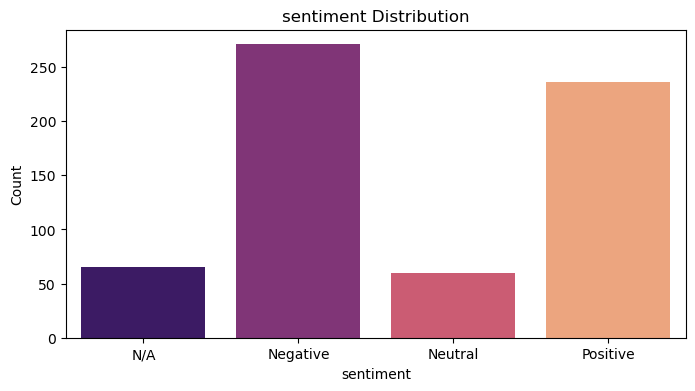

In [37]:

# 5. Potential Biases - Distribution of Ratings
sentiment_counts = df['sentiment_clean'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="magma")
plt.title("sentiment Distribution")
plt.xlabel("sentiment")
plt.ylabel("Count")
plt.show()

In [38]:
mask = df['sentiment_clean'] == "Positive"
df[mask]['rating'].value_counts()

rating
5    130
4     58
1     38
3      6
2      4
Name: count, dtype: int64

## Next step: Enhancement: Improve Prompting with Language Context  

### 📝 Description  
Feeding language context into GPT can significantly enhance the quality and relevance of responses. By specifying the language, GPT can adjust grammar, style, and nuances more effectively.



## Evaluate model using confustion matrix

<Figure size 600x500 with 0 Axes>

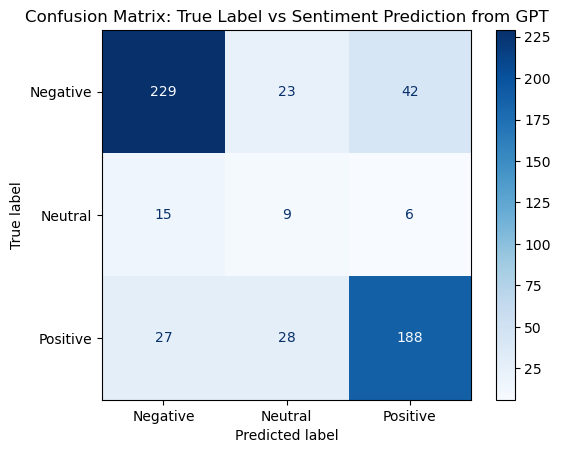

In [39]:
labels = ["Negative", "Neutral", "Positive"]
plot_confusion_matrix(df, true_col="true_label", pred_col="sentiment_clean", labels=labels, 
                      title="Confusion Matrix: True Label vs Sentiment Prediction from GPT")

In [40]:
metrics = evaluate_classification(df, "true_label", "sentiment_clean")

Accuracy: 0.6741
Precision: 0.7871
Recall: 0.6741
F1 Score: 0.7246


/Users/chin-jung.kuo/miniconda3/envs/EDA_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 🎯 Choosing the Right Metric: Precision vs. Recall vs. F1-score  

- 🔹 **If misclassifying a certain class** (e.g., **"Positive" as "Neutral"**) is a major issue, focus on **Recall**.  
- 🔹 **If you want predictions to be very confident** when labeling a class (e.g., GPT predicting only when it’s sure), focus on **Precision**.  
- 🔹 **For overall balance**, **F1-score** is used (harmonic mean of **Precision** and **Recall**).  

### 📌 **Considering Advanced Metrics: Polarity**
For a more advanced evaluation, **intensity or polarity** could be considered to capture sentiment intensity.

### ⚡ **Our Focus:**
Since our goal is to **identify sentiment and take action**, we should **prioritize both Precision and Recall**.  
Thus, we will focus **more on the F1-score** as it balances both aspects effectively.